# SWB Regression Pipeline - HFA Power 
Created: 07/30/24 \
Updated: 08/19/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08192024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [7]:
hfa_df = pd.read_csv(f'{save_dir}hfa_master_df.csv')
hfa_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [12]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

# # keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
# #     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# # keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
# # keep_rois


# Test Single Electrode Regressions 

In [10]:
elec_col    = 'unique_reref_ch'
main_var    = 'decisionCPE'
reg_formula = 'band_pow~GambleChoice+TotalProfit+decisionCPE'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(hfa_df,reg_formula,elec_col, main_var,n_permutations)

Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4115.38it/s]


In [11]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'decisionCPE']

In [12]:
results = single_elec_permutation_results(results_dict,hfa_df,save_vars)
results

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.003760,-0.000212,...,0.010445,0.010250,1.658453,-1.658453,-2.398505,2.079861,0.097226,0.097226,0.016462,0.037538
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.004866,0.000058,...,0.012912,0.012501,1.868318,-1.868318,-1.631416,2.630727,0.061718,0.061718,0.102803,0.008520
2,MS002_lacas3-lacas4,MS002,acc,14,0.018103,-0.030073,-0.034169,0.000575,-0.003411,0.001026,...,0.012830,0.013024,2.330740,-2.330740,-2.675613,0.055871,0.019767,0.019767,0.007459,0.955444
3,MS002_lacas4-lacas5,MS002,acc,14,0.015891,-0.022747,-0.039756,0.001034,-0.000273,0.000619,...,0.014126,0.014019,1.514582,-1.514582,-2.779672,0.086132,0.129878,0.129878,0.005441,0.931361
4,MS002_lacas5-lacas6,MS002,acc,14,0.023452,-0.028664,-0.008658,-0.003695,0.004062,-0.000635,...,0.012507,0.012012,2.061621,-2.061621,-0.639261,-0.299367,0.039244,0.039244,0.522653,0.764660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875,DA039_rtp6-rtp7,DA039,temporal pole,22,-0.020897,0.000284,-0.017221,0.003491,-0.021090,0.000787,...,0.016274,0.015852,0.030296,-0.030296,-1.024167,0.200671,0.975831,0.975831,0.305757,0.840956
1876,DA039_rtp7-rtp8,DA039,temporal pole,22,-0.018445,-0.013477,-0.002231,0.008746,-0.023510,-0.000264,...,0.017379,0.016880,0.755130,-0.755130,-0.209364,0.534241,0.450171,0.450171,0.834164,0.593174
1877,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.096861,0.042294,0.026198,0.028030,-0.080947,0.000777,...,0.021456,0.022444,-1.892501,1.892501,1.210332,1.234083,0.058424,0.058424,0.226151,0.217172
1878,DA039_rsgcc7-rsgcc8,DA039,vlpfc,22,-0.087831,0.032648,0.035573,-0.006513,-0.074472,-0.002203,...,0.022339,0.021304,-1.549594,1.549594,1.624794,-0.351343,0.121239,0.121239,0.104206,0.725331


In [13]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_hfa_{reg_formula}_{date}.pkl',"wb"))

In [14]:
sig_data = results[results.unique_elec_id.isin(main_var_sig)]
sig_data

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.003760,-0.000212,...,0.010445,0.010250,1.658453,-1.658453,-2.398505,2.079861,0.097226,0.097226,0.016462,0.037538
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.004866,0.000058,...,0.012912,0.012501,1.868318,-1.868318,-1.631416,2.630727,0.061718,0.061718,0.102803,0.008520
47,MS002_lpips3-lpips4,MS002,pins,14,0.015306,-0.032655,-0.033791,-0.044934,-0.007318,0.000049,...,0.020794,0.019706,1.496496,-1.496496,-1.601064,-2.235781,0.134524,0.134524,0.109363,0.025366
56,MS002_lsif6-lsif7,MS002,motor,14,0.006094,0.003891,0.004608,0.034153,0.008488,0.000430,...,0.013764,0.013825,-0.224297,0.224297,0.380713,2.491065,0.822526,0.822526,0.703417,0.012736
61,MS002_racas6-racas7,MS002,dmpfc,14,0.021060,-0.002760,-0.027003,-0.028567,0.019728,-0.000835,...,0.014007,0.014118,0.134086,-0.134086,-1.910765,-1.992075,0.893335,0.893335,0.056035,0.046363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,DA026_lpsmg6-lpsmg7,DA026,smg,19,-0.019041,0.044134,0.011911,0.026207,0.004961,-0.000202,...,0.012537,0.012842,-3.513509,3.513509,0.979637,2.034663,0.000442,0.000442,0.327265,0.041885
1793,DA037_rsmg15-rsmg16,DA037,smg,4,-0.001303,0.012758,0.027633,-0.032089,0.001777,-0.000331,...,0.014386,0.015403,-0.732543,0.732543,1.938418,-2.065916,0.463837,0.463837,0.052572,0.038836
1805,DA037_rof1-rof2,DA037,ofc,4,-0.012610,0.001246,0.034839,0.060822,-0.012401,0.000361,...,0.023891,0.023348,-0.031165,0.031165,1.449466,2.615704,0.975138,0.975138,0.147208,0.008904
1812,DA037_rmc7-rmc8,DA037,dlpfc,4,-0.026976,0.074267,0.029557,-0.061234,-0.009443,-0.000249,...,0.020354,0.021174,-3.053433,3.053433,1.486911,-2.911473,0.002262,0.002262,0.137038,0.003597


In [15]:
sig_data.roi.value_counts()

acc          33
ofc          22
dmpfc        15
ains         12
smg          11
vlpfc        10
hpc          10
sts           9
amy           9
dlpfc         8
stg           7
vmpfc         7
pins          5
mcc           5
thalamus      4
motor         4
mtg           3
parietal      2
occipital     2
phg           1
pcc           1
angular       1
Name: roi, dtype: int64

In [16]:
sig_data.roi.unique()

array(['acc', 'pins', 'motor', 'dmpfc', 'mtg', 'vmpfc', 'ains', 'ofc',
       'vlpfc', 'stg', 'mcc', 'sts', 'amy', 'dlpfc', 'hpc', 'phg',
       'parietal', 'thalamus', 'smg', 'pcc', 'occipital', 'angular'],
      dtype=object)

In [17]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


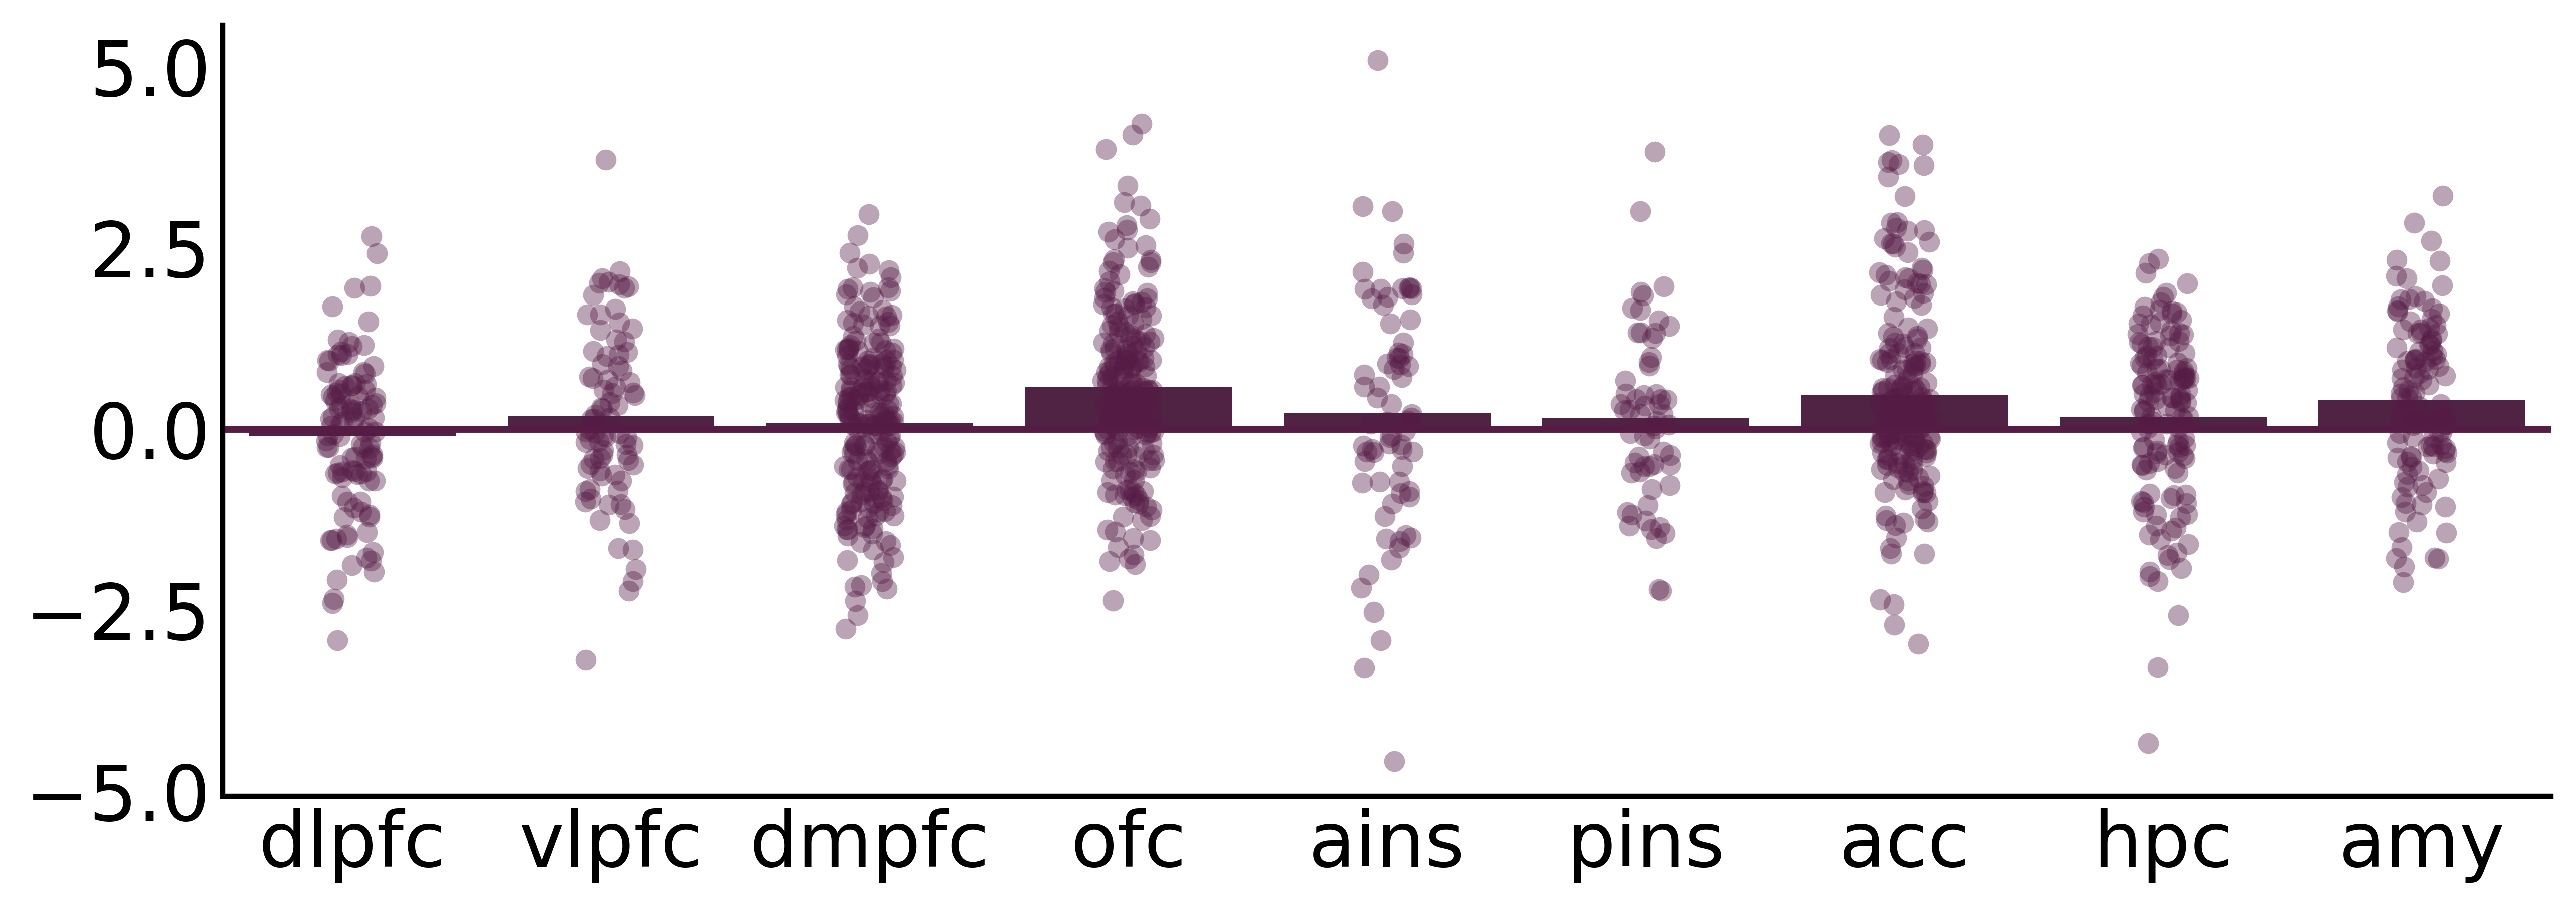

In [18]:
plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,4),color='#561C46')
# green '#135546'


In [19]:
results.groupby('roi').agg('mean')['Z_Score_decisionCPE'][bar_order]

roi
dlpfc   -0.095070
vlpfc    0.177339
dmpfc    0.089286
ofc      0.576216
ains     0.218913
pins     0.159847
acc      0.478034
hpc      0.173374
amy      0.404580
Name: Z_Score_decisionCPE, dtype: float64

In [25]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.003760,-0.000212,...,0.010445,0.010250,1.658453,-1.658453,-2.398505,2.079861,0.097226,0.097226,0.016462,0.037538
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.004866,0.000058,...,0.012912,0.012501,1.868318,-1.868318,-1.631416,2.630727,0.061718,0.061718,0.102803,0.008520
2,MS002_lacas3-lacas4,MS002,acc,14,0.018103,-0.030073,-0.034169,0.000575,-0.003411,0.001026,...,0.012830,0.013024,2.330740,-2.330740,-2.675613,0.055871,0.019767,0.019767,0.007459,0.955444
3,MS002_lacas4-lacas5,MS002,acc,14,0.015891,-0.022747,-0.039756,0.001034,-0.000273,0.000619,...,0.014126,0.014019,1.514582,-1.514582,-2.779672,0.086132,0.129878,0.129878,0.005441,0.931361
4,MS002_lacas5-lacas6,MS002,acc,14,0.023452,-0.028664,-0.008658,-0.003695,0.004062,-0.000635,...,0.012507,0.012012,2.061621,-2.061621,-0.639261,-0.299367,0.039244,0.039244,0.522653,0.764660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1862,DA039_rpins1-rpins2,DA039,pins,22,-0.000885,-0.018211,0.018350,0.001634,-0.007966,0.000259,...,0.017491,0.017366,1.027884,-1.027884,1.058850,0.111642,0.304005,0.304005,0.289668,0.911108
1863,DA039_rpins2-rpins3,DA039,pins,22,-0.000429,-0.038045,0.028140,-0.020577,-0.015014,0.000003,...,0.027137,0.025803,1.387970,-1.387970,1.050968,-0.829869,0.165146,0.165146,0.293273,0.406613
1864,DA039_rpins3-rpins4,DA039,pins,22,0.001596,-0.051768,0.039688,-0.042583,-0.017292,-0.002495,...,0.037704,0.039533,1.287421,-1.287421,1.043984,-1.049662,0.197948,0.197948,0.296493,0.293874
1877,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.096861,0.042294,0.026198,0.028030,-0.080947,0.000777,...,0.021456,0.022444,-1.892501,1.892501,1.210332,1.234083,0.058424,0.058424,0.226151,0.217172


In [31]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)

In [32]:
agg_single_results = single_elec_res.groupby('roi').agg('mean')[['Z_Score_decisionCPE']].copy()

agg_single_results


,Z_Score_decisionCPE
roi,
acc,0.478034
ains,0.218913
amy,0.404580
dlpfc,-0.095070
dmpfc,0.089286
hpc,0.173374
ofc,0.576216
pins,0.159847
vlpfc,0.177339


In [33]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_decisionCPE'] = agg_single_results.Z_Score_decisionCPE
single_rho_data

,rho,rho_p,Z_Score_decisionCPE
roi,,,
acc,-0.160363,0.0259,0.478034
dmpfc,-0.139515,0.0405,0.089286
amy,-0.295977,0.0015,0.404580
ains,-0.210936,0.0774,0.218913
vlpfc,-0.042882,0.7021,0.177339
hpc,-0.155326,0.0720,0.173374
ofc,0.039385,0.5779,0.576216
pins,-0.074102,0.5736,0.159847
dlpfc,-0.039493,0.6863,-0.095070


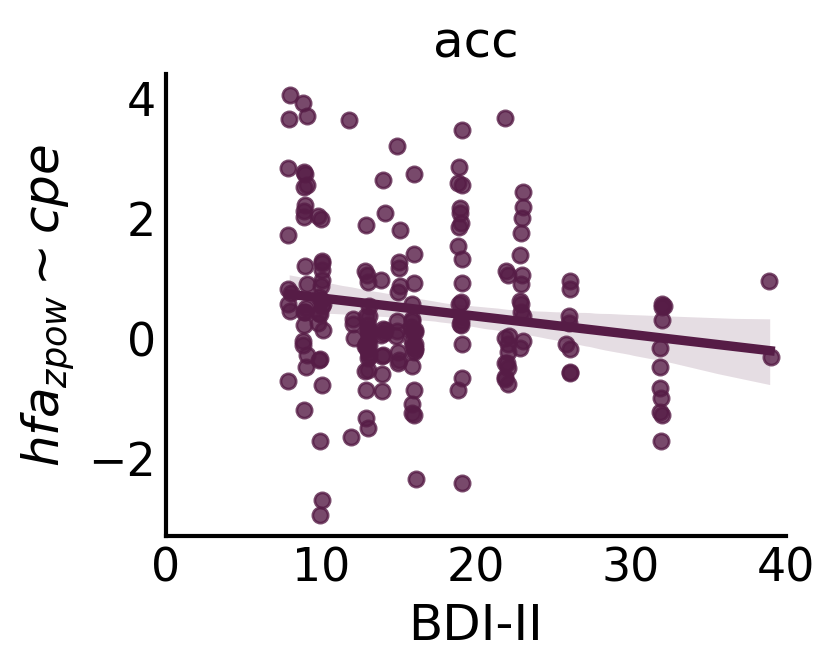

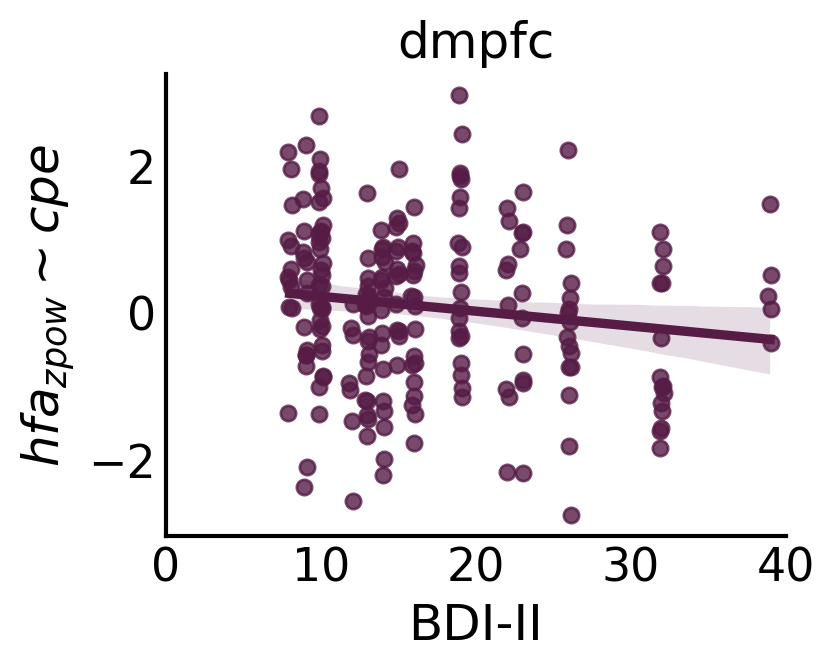

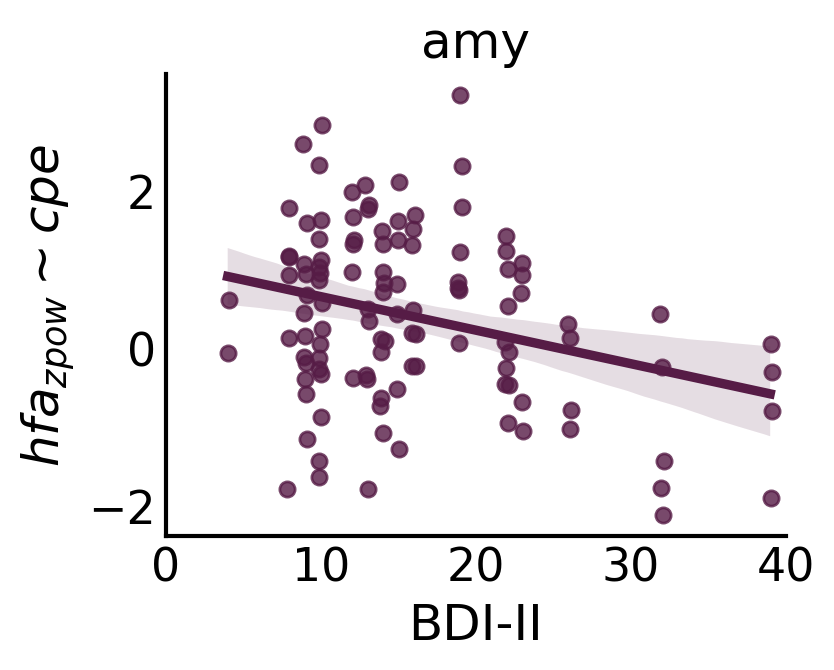

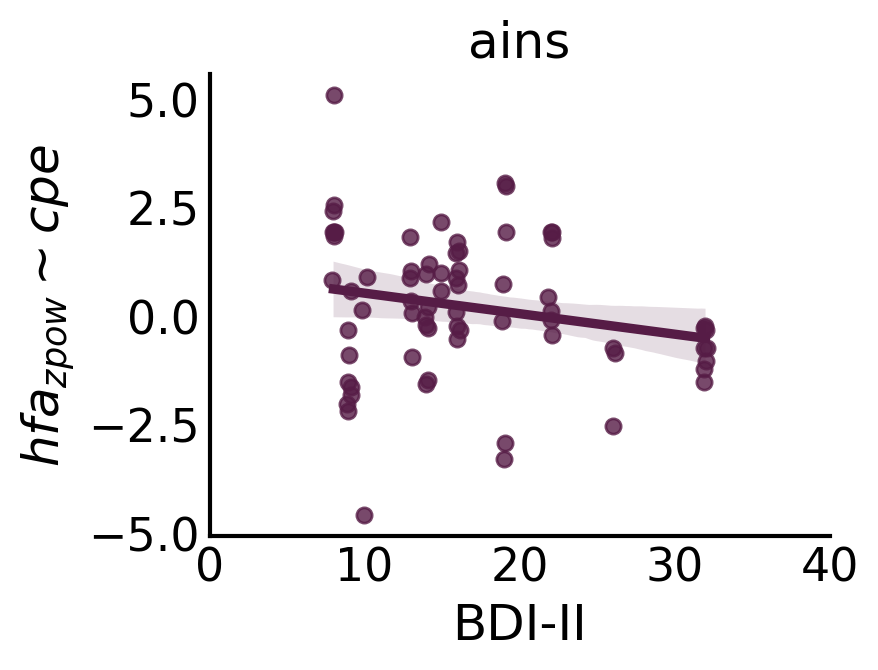

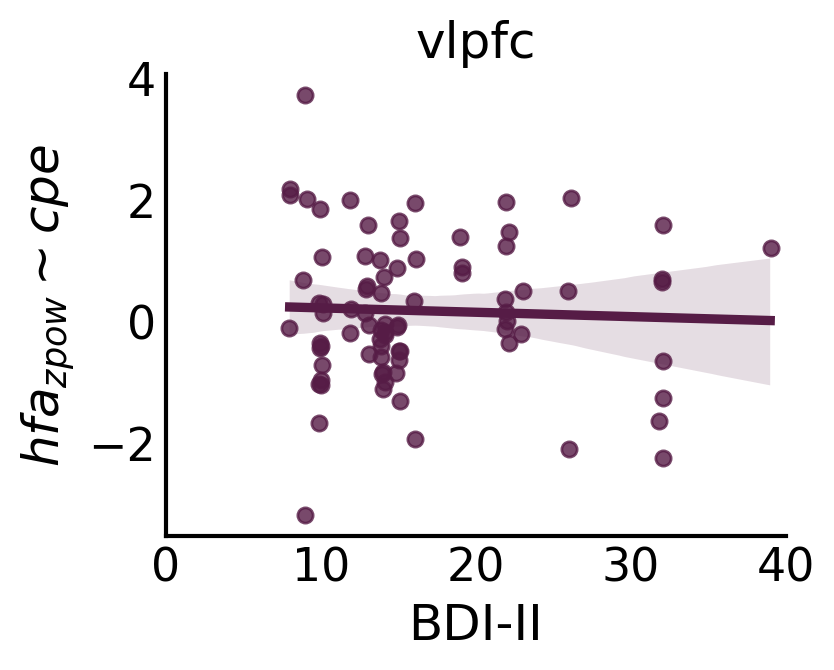

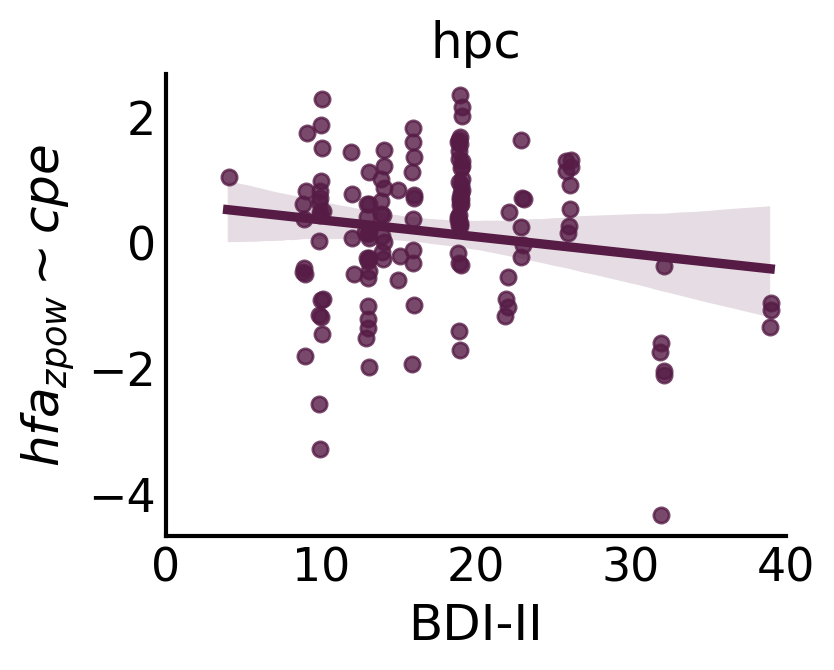

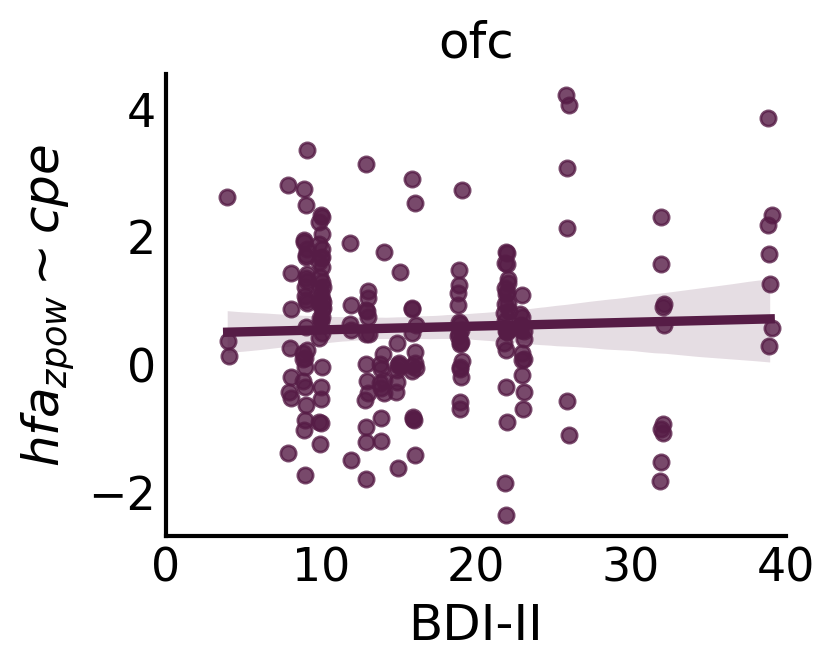

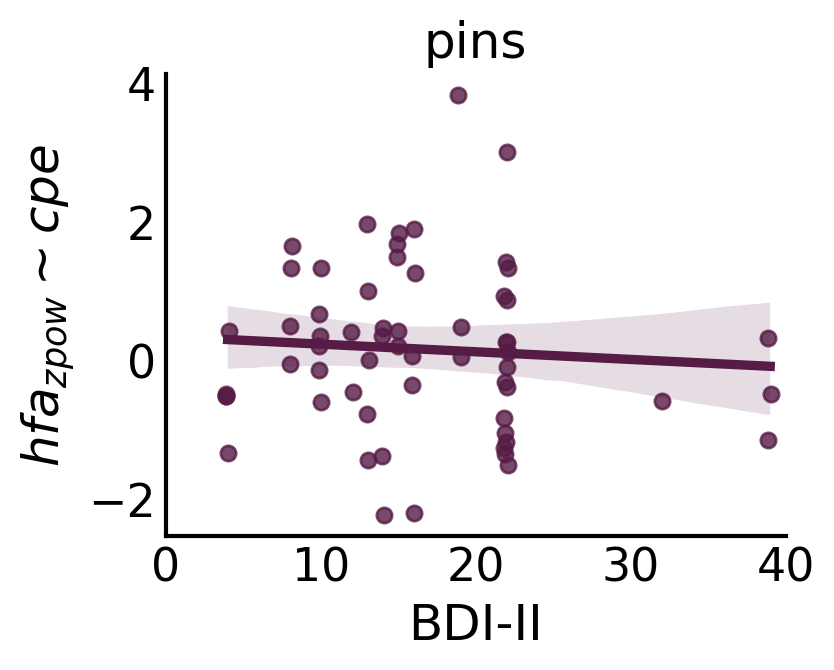

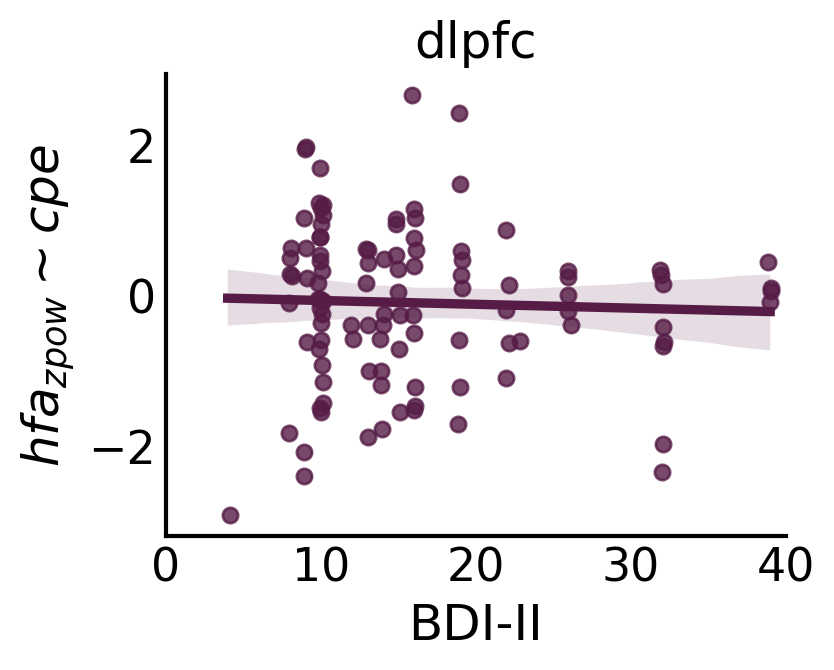

In [34]:
band = 'hfa'

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = '#561C46',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()


# Mixed effects models

In [35]:
reg_df = hfa_df.copy()
reg_df = reg_df[reg_df.roi.isin(bar_order)]
reg_df


,Unnamed: 0,subj_id,bdi,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,...,SafeBet,GambleChoice,GambleChoice_t1,TrialEV,Profit,TotalProfit,RPE,decisionCPE,decisionRegret,decisionRelief
0,0,MS002,14,lacas1-lacas2,MS002_lacas1-lacas2,0,118.986976,hfa,-0.015832,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
1,1,MS002,14,lacas2-lacas3,MS002_lacas2-lacas3,0,118.986976,hfa,-0.053265,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
2,2,MS002,14,lacas3-lacas4,MS002_lacas3-lacas4,0,118.986976,hfa,-0.019960,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
3,3,MS002,14,lacas4-lacas5,MS002_lacas4-lacas5,0,118.986976,hfa,-0.061600,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
4,4,MS002,14,lacas5-lacas6,MS002_lacas5-lacas6,0,118.986976,hfa,-0.195597,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258455,258455,DA039,22,rpins1-rpins2,DA039_rpins1-rpins2,148,118.986976,hfa,-0.164942,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258456,258456,DA039,22,rpins2-rpins3,DA039_rpins2-rpins3,148,118.986976,hfa,-0.115631,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258457,258457,DA039,22,rpins3-rpins4,DA039_rpins3-rpins4,148,118.986976,hfa,-0.193613,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258470,258470,DA039,22,rsgcc6-rsgcc7,DA039_rsgcc6-rsgcc7,148,118.986976,hfa,-0.162934,vlpfc,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244


In [36]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'decisionCPE','roi','hemi','bdi','bdi:decisionCPE']
rand_vars    = ['GambleChoice','TotalProfit', 'decisionCPE']


In [37]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [38]:
roi_fit_results['band'] = 'hfa'
# roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

# raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
#                  popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
# raw_roi_stats

In [39]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]
fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],hemi[T.r],TotalProfit,decisionCPE,bdi,bdi:decisionCPE,roi,cpe_pval,bdi_pval,cpe_bdi_pval
0,-0.001170,-0.006725,0.003880,-0.016278,0.011847,-0.000211,-0.000353,acc,0.0004,0.1798,0.0604
1,-0.012823,0.003165,0.009863,-0.016015,0.005782,0.000083,-0.000282,dmpfc,0.0804,0.7410,0.1177
2,-0.011194,0.004100,-0.003365,0.004985,0.018018,-0.000703,-0.000786,amy,0.0001,0.1369,0.0024
3,0.010936,0.000427,0.011294,0.001492,0.013960,-0.000753,-0.000628,ains,0.0535,0.1488,0.1184
4,-0.015014,0.008152,-0.001037,-0.012118,0.006527,0.000544,-0.000196,vlpfc,0.3438,0.3994,0.6144
5,-0.118569,0.006704,-0.017159,0.000568,0.013542,0.003443,-0.000727,hpc,0.0083,0.0135,0.0092
6,0.004837,0.013501,-0.014745,-0.011378,0.009104,-0.001022,0.000083,ofc,0.0217,0.0655,0.7014
7,-0.072810,-0.001643,0.047446,0.008999,0.005200,-0.000439,-0.000261,pins,0.4858,0.8350,0.5236
8,-0.003768,0.016253,-0.006951,-0.011643,-0.000470,-0.000479,0.000116,dlpfc,0.9364,0.2963,0.7108


In [40]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha

0.005555555555555556

In [41]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois

['acc', 'amy']

In [42]:
sig_cpe_bdi_rois = fe_results.roi[fe_results.cpe_bdi_pval <= bonferr_alpha].tolist()
sig_cpe_bdi_rois

['amy']

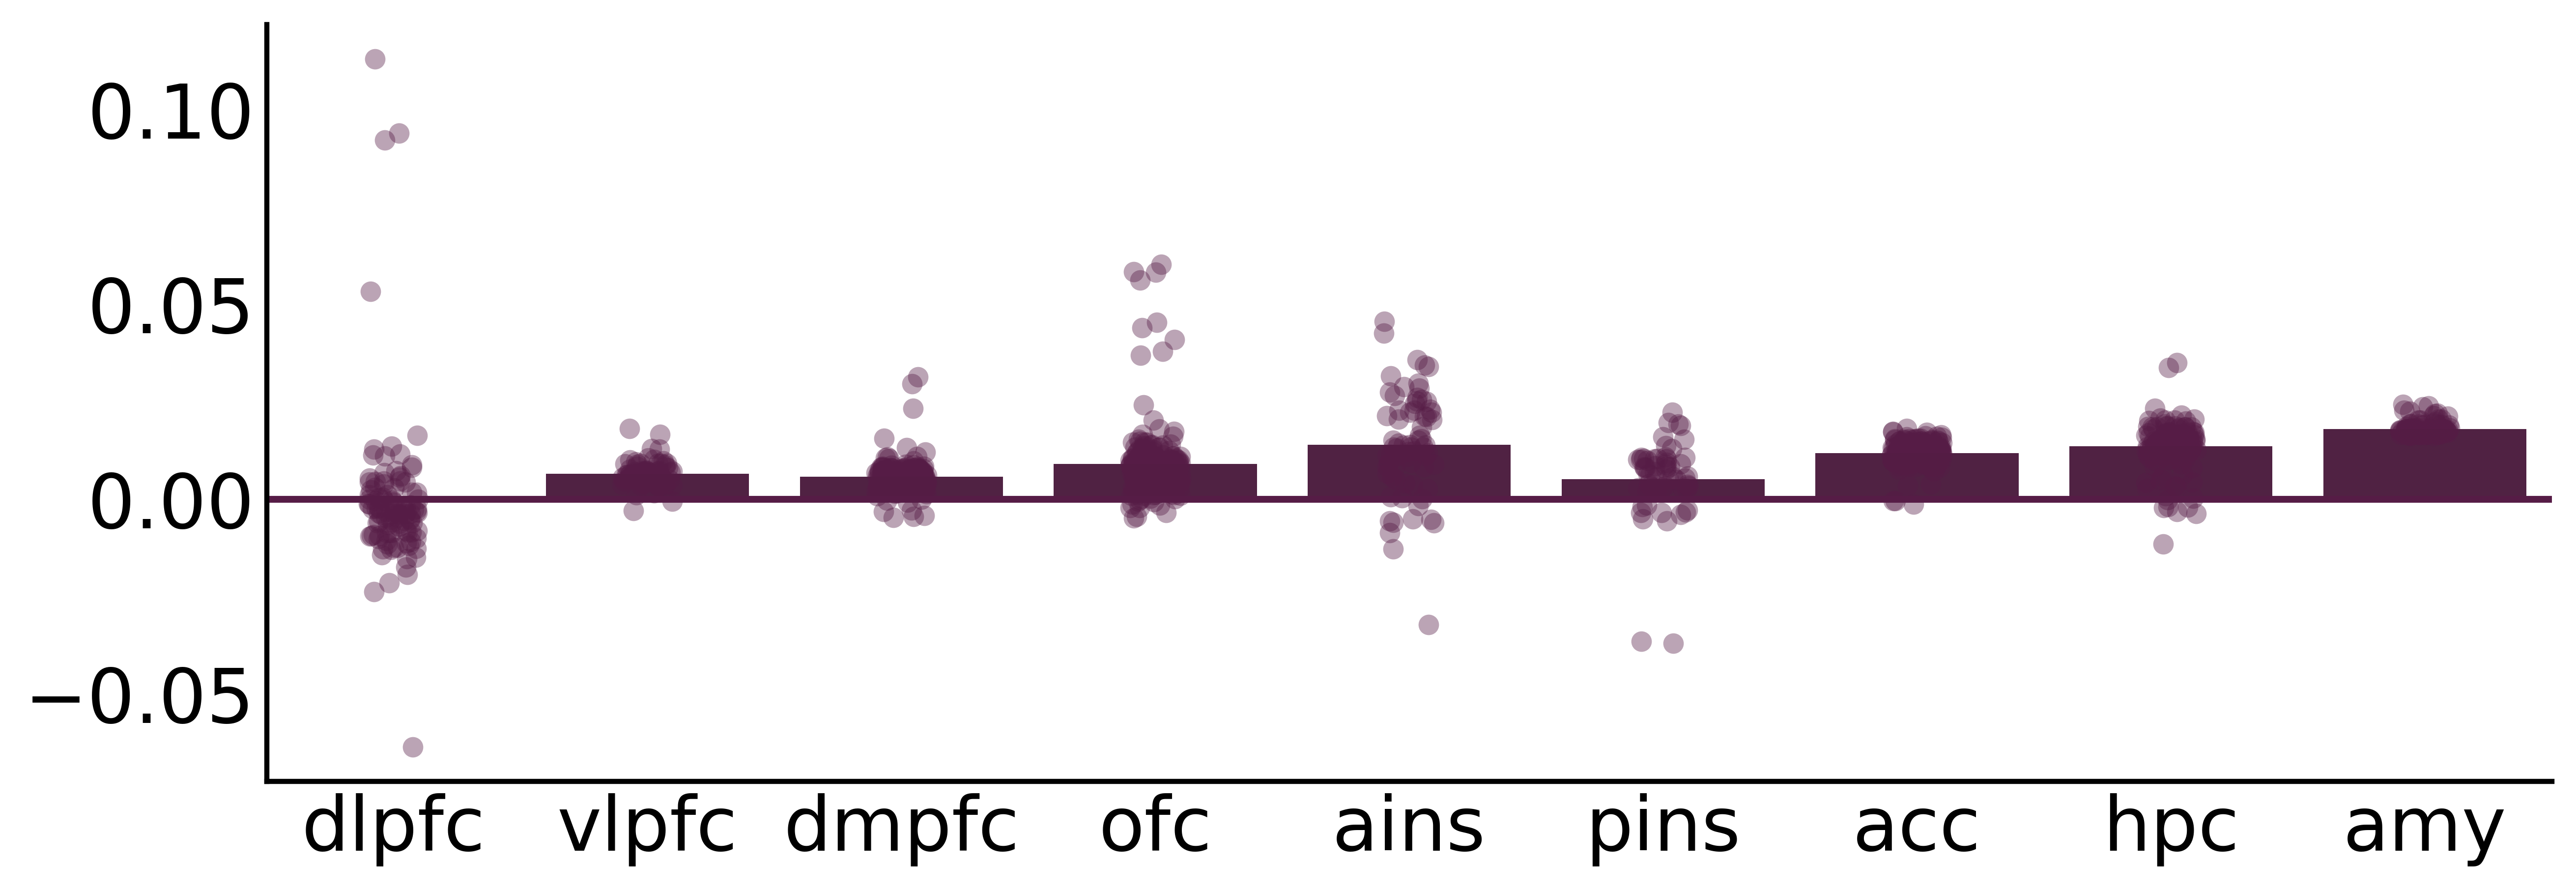

In [43]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=bar_order,figsize=(12,4),color='#561C46')


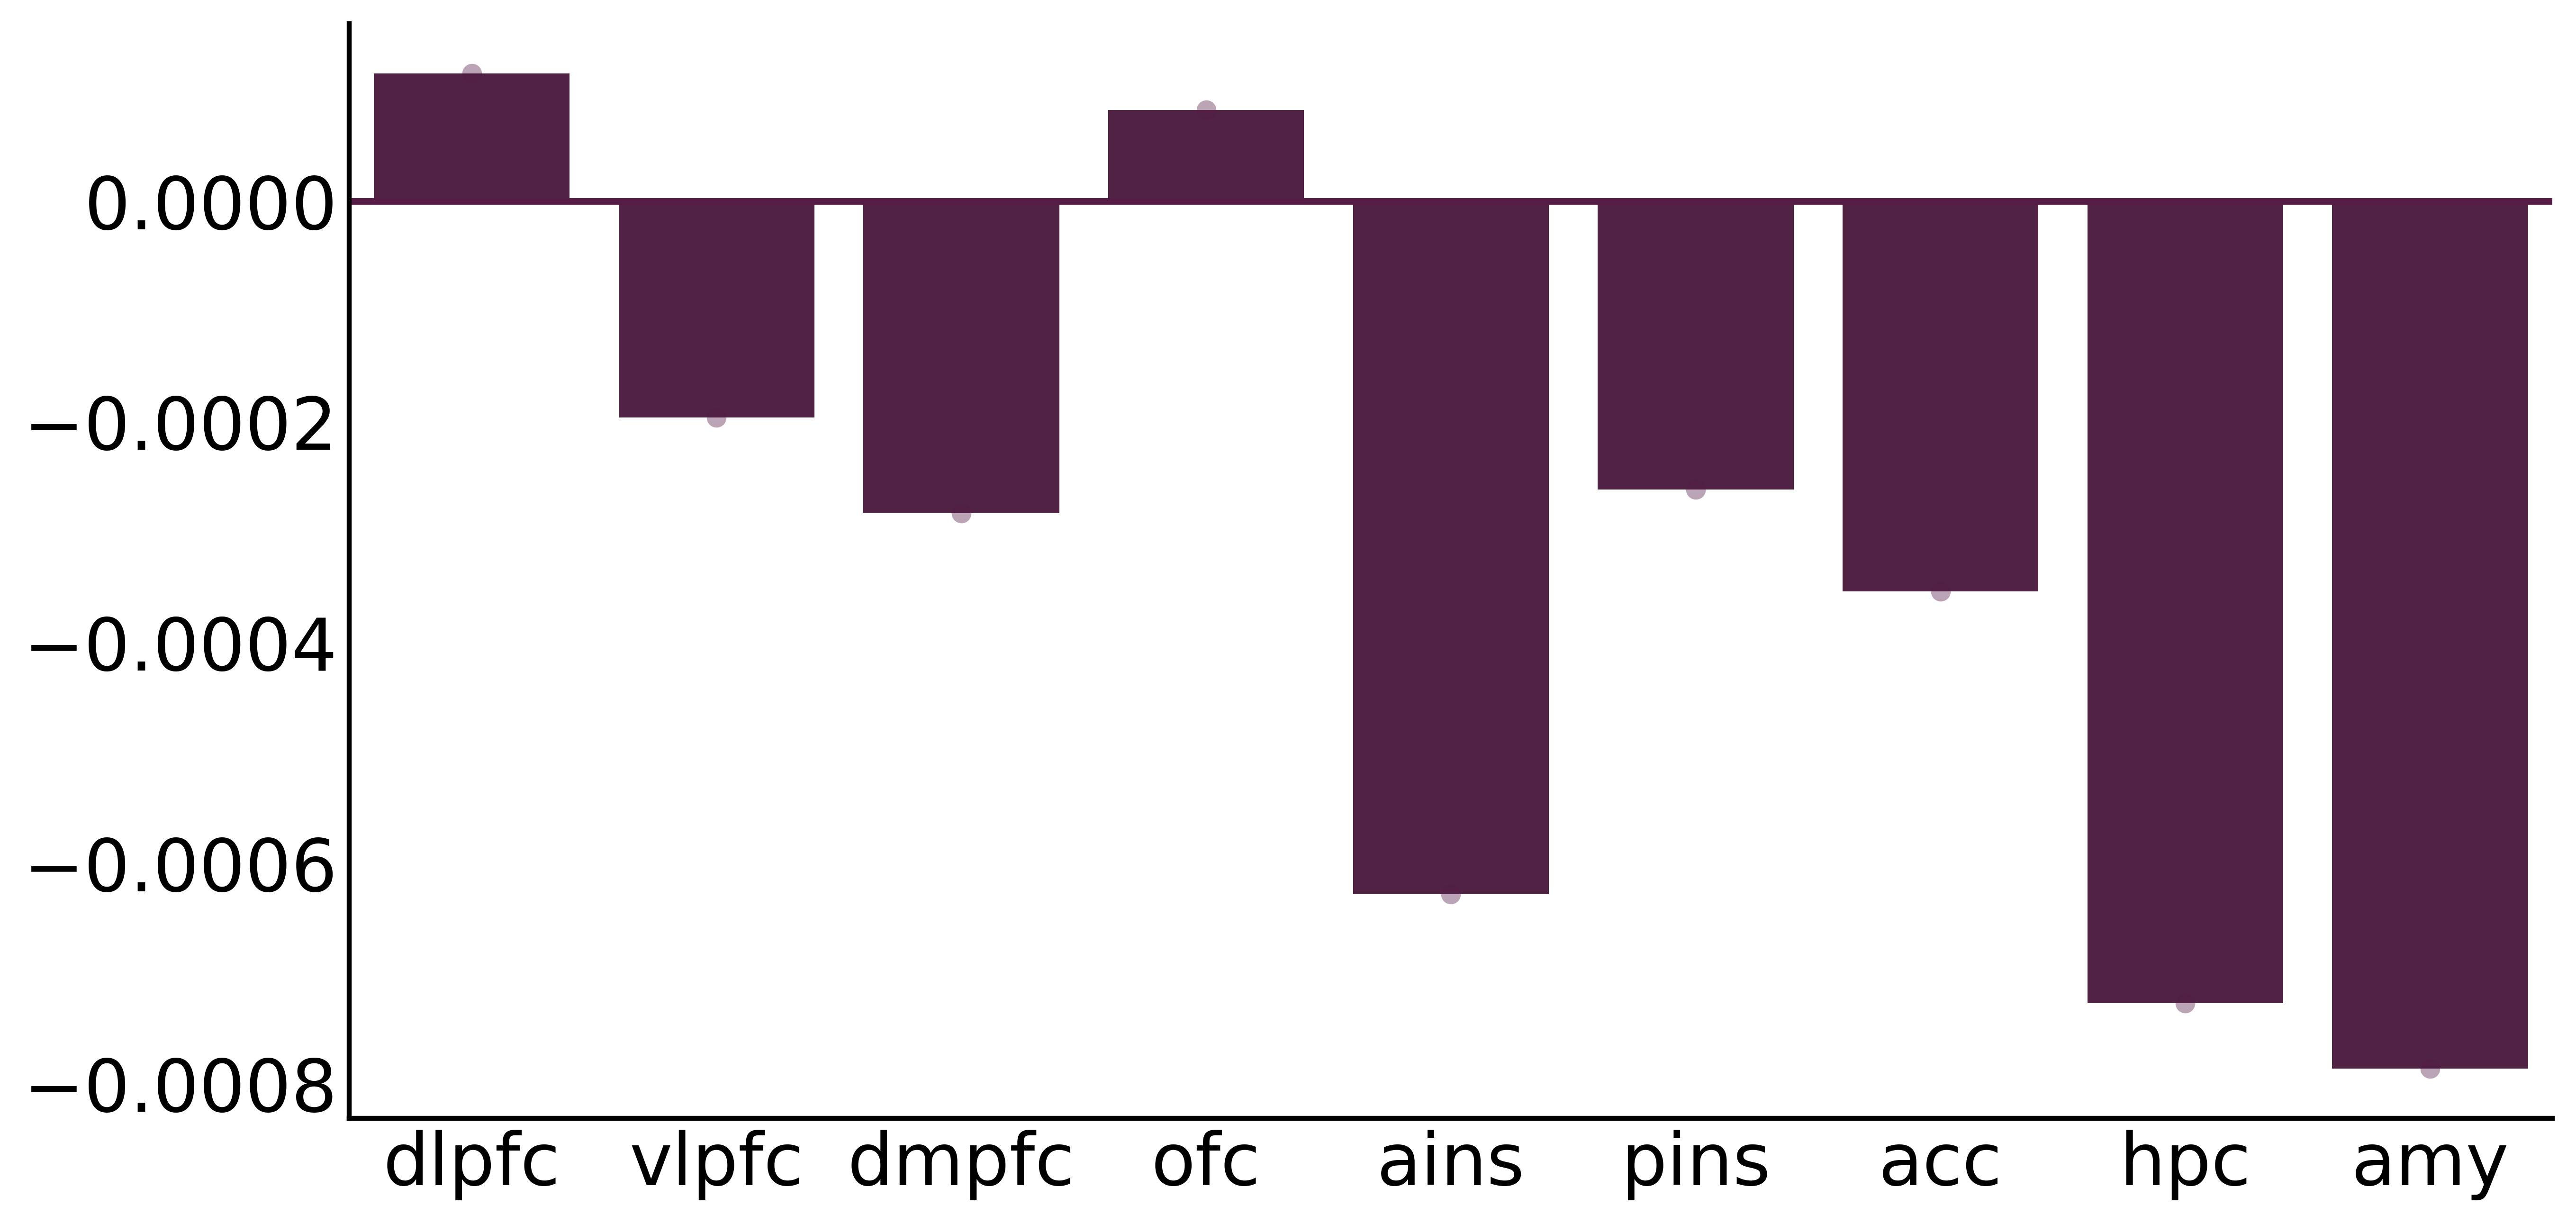

In [44]:
plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#561C46')
# add to slides 
